In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


import re
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



import spacy
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv(r'/content/Imdb - data_imdb.csv', engine='python', on_bad_lines = 'skip')

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data.sample()

,review,sentiment
2927,I felt like I was watching an example of how n...,negative


In [5]:
data.isnull().sum()

,0
review,0
sentiment,0


##We check for missing values, class balance, and review length distribution.

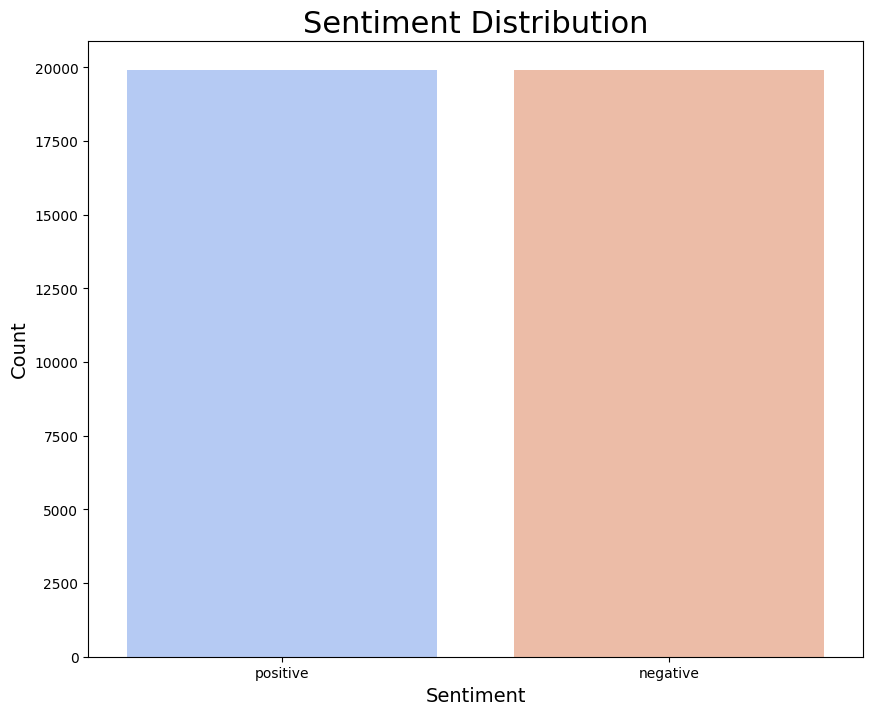

In [6]:
plt.figure(figsize=(10,8))
sns.countplot(x='sentiment', data=data, palette='coolwarm')
plt.title("Sentiment Distribution", size = 22)
plt.xlabel("Sentiment", size = 14)
plt.ylabel("Count", size = 14)
plt.show()


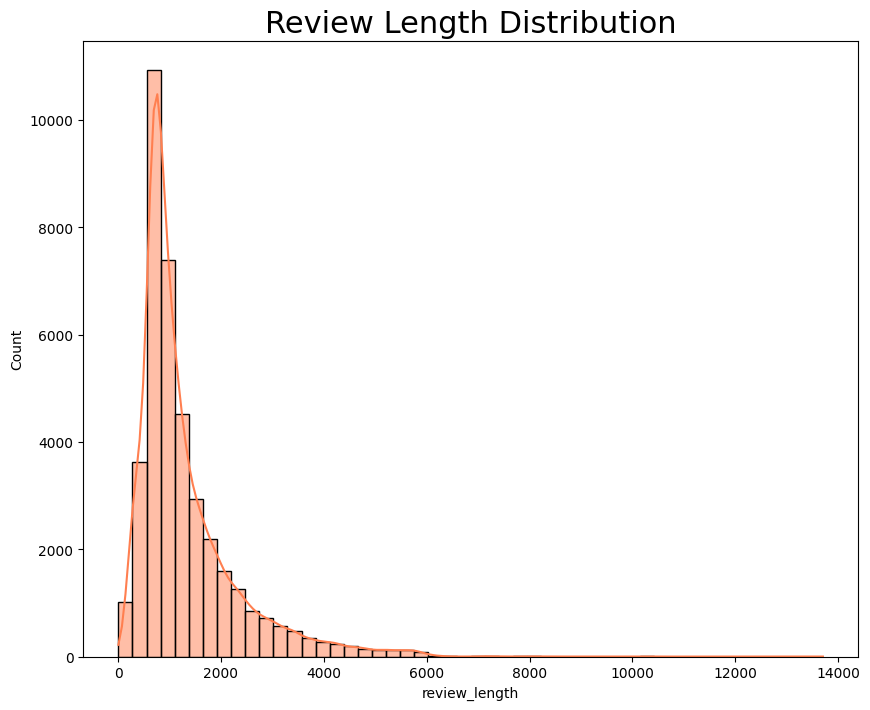

In [7]:

data['review_length'] = data['review'].apply(len)

plt.figure(figsize=(10,8))
sns.histplot(data['review_length'], bins=50, kde=True, color ='coral')
plt.title("Review Length Distribution", size = 22)
plt.show()

##Cleaned reviews by making them lowercase and removing punctuation, special characters, and HTML tags.

In [8]:
def clean_text(text):
    text = text.lower()                              # lowercase
    text = re.sub(r'<.*?>', '', text)                # remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)       # remove punctuation/special chars
    text = re.sub(r'\s+', ' ', text).strip()         # remove extra spaces
    return text

data['cleaned_review'] = data['review'].apply(clean_text)
print(data[['review', 'cleaned_review']].head())


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production the filming tech...  
2  i thought this was a wonderful way to spend ti...  
3  basically theres a family where a little boy j...  
4  petter matteis love in the time of money is a ...  


##Split reviews into words so the model can understand them as tokens.

In [9]:
data['tokens'] = data['cleaned_review'].apply(word_tokenize)
print(data[['cleaned_review', 'tokens']].head())


                                      cleaned_review  \
0  one of the other reviewers has mentioned that ...   
1  a wonderful little production the filming tech...   
2  i thought this was a wonderful way to spend ti...   
3  basically theres a family where a little boy j...   
4  petter matteis love in the time of money is a ...   

                                              tokens  
0  [one, of, the, other, reviewers, has, mentione...  
1  [a, wonderful, little, production, the, filmin...  
2  [i, thought, this, was, a, wonderful, way, to,...  
3  [basically, theres, a, family, where, a, littl...  
4  [petter, matteis, love, in, the, time, of, mon...  


##Removed common words (like is, the, and) that don’t add meaning.

In [10]:
stop_words = set(stopwords.words('english'))
data['filtered_tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
print(data[['tokens', 'filtered_tokens']].head())


                                              tokens  \
0  [one, of, the, other, reviewers, has, mentione...   
1  [a, wonderful, little, production, the, filmin...   
2  [i, thought, this, was, a, wonderful, way, to,...   
3  [basically, theres, a, family, where, a, littl...   
4  [petter, matteis, love, in, the, time, of, mon...   

                                     filtered_tokens  
0  [one, reviewers, mentioned, watching, 1, oz, e...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, theres, family, little, boy, jake,...  
4  [petter, matteis, love, time, money, visually,...  


##Converted words to their base form (running → run, better → good).

In [11]:
lemmatizer = WordNetLemmatizer()
data['lemmatized_tokens'] = data['filtered_tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print(data[['filtered_tokens', 'lemmatized_tokens']].head())


                                     filtered_tokens  \
0  [one, reviewers, mentioned, watching, 1, oz, e...   
1  [wonderful, little, production, filming, techn...   
2  [thought, wonderful, way, spend, time, hot, su...   
3  [basically, theres, family, little, boy, jake,...   
4  [petter, matteis, love, time, money, visually,...   

                                   lemmatized_tokens  
0  [one, reviewer, mentioned, watching, 1, oz, ep...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, there, family, little, boy, jake, ...  
4  [petter, matteis, love, time, money, visually,...  


##Visualized frequent words in positive and negative reviews.

In [12]:
positive_text = ' '.join(data[data['sentiment'] == 'positive']['cleaned_review'])
negative_text = ' '.join(data[data['sentiment'] == 'negative']['cleaned_review'])

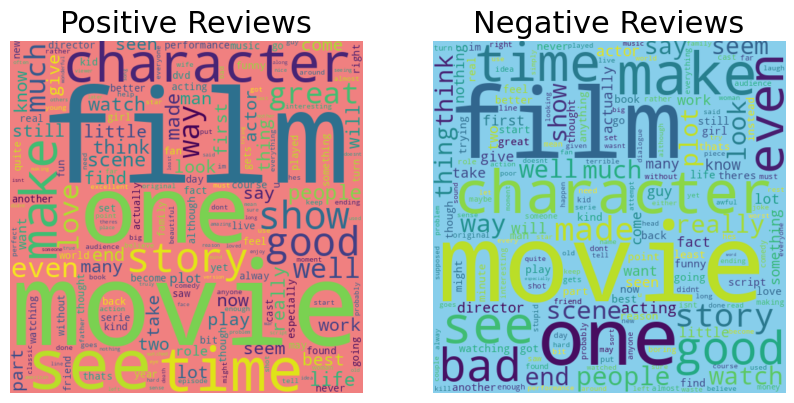

In [13]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
wordcloud = WordCloud(width = 500, height = 500, background_color = 'lightcoral').generate(positive_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Positive Reviews', size = 22)

plt.subplot(1,2,2)
wordcloud = WordCloud(width = 500, height = 500, background_color = 'skyblue').generate(negative_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Negative Reviews', size = 22)

plt.show()

##Feature Extraction:- (TF-IDF & BoW)

    1. Bag-of-Words(BoW):-
      a. Counts how many times a word appears in a review.
      b. Simple but does not consider word importance.
    2. TF-IDF(Term Frequency-Inverse Document Frequency):
      a. Weighs words by importance.
      b. Common words accross all reviews(e.g. movie, film) get lower weight.
      c. Unique/relevent words(e.g. masterpiece, boring) get higher weight.

In [14]:
bow_vectorizer = CountVectorizer(max_features= 5000)
X_bow = bow_vectorizer.fit_transform(data['cleaned_review']).toarray()

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['cleaned_review']).toarray()


print('Bow Shape: ', X_bow.shape)
print('TF-IDF Shape: ', X_tfidf.shape)

Bow Shape:  (39813, 5000)
TF-IDF Shape:  (39813, 5000)


## Added extra features that help models capture more info:
    a. Word count(Total words in review).
    b. Character count(length of review).
    c. Average Word length.
    

In [15]:
data['word_count'] = data['cleaned_review'].apply(lambda x: len(x.split()))

data['char_count'] = data['cleaned_review'].apply(len)

data['avg_word_len'] = data['char_count'] / (data['word_count']+1)

print(data[['review', 'word_count', 'char_count', 'avg_word_len']].head())


                                              review  word_count  char_count  \
0  One of the other reviewers has mentioned that ...         301        1665   
1  A wonderful little production. <br /><br />The...         156         936   
2  I thought this was a wonderful way to spend ti...         162         874   
3  Basically there's a family where a little boy ...         129         685   
4  Petter Mattei's "Love in the Time of Money" is...         222        1237   

   avg_word_len  
0      5.513245  
1      5.961783  
2      5.361963  
3      5.269231  
4      5.547085  


##Instead of just counting words, Embaddings(Word2Vec, Flove, BERT) captures semantic meaning.

In [16]:
nlp = spacy.load("en_core_web_sm")

def get_avg_embedding(text):
    doc = nlp(text)
    return doc.vector

data['embedding'] = data['cleaned_review'].apply(get_avg_embedding)
print(data['embedding'].head())


0    [0.20197177, -0.18574892, 0.07216207, -0.03703...
1    [0.45796973, -0.12617923, 0.00238203, 0.072106...
2    [0.2789968, -0.24232018, 0.13097167, -0.001403...
3    [0.2567957, -0.20964845, 0.04202698, 0.1182934...
4    [0.33086646, -0.2069584, 0.003507328, 0.190986...
Name: embedding, dtype: object


In [17]:
from sklearn.model_selection import train_test_split

# Use TF-IDF features
X = X_tfidf
y = data['sentiment'].map({'positive':1, 'negative':0})  # convert labels to binary

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (31850, 5000)
Testing set size: (7963, 5000)


##**Logistic Regression**
####A simple yet powerful linear model for classification.

In [18]:
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.8883586587969359
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3945
           1       0.89      0.89      0.89      4018

    accuracy                           0.89      7963
   macro avg       0.89      0.89      0.89      7963
weighted avg       0.89      0.89      0.89      7963



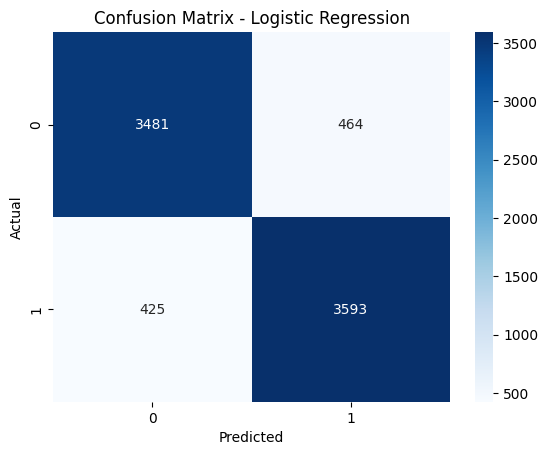

In [19]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


##**Based on probability (Bayes’ theorem).**

In [20]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8511867386663318
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3945
           1       0.85      0.85      0.85      4018

    accuracy                           0.85      7963
   macro avg       0.85      0.85      0.85      7963
weighted avg       0.85      0.85      0.85      7963



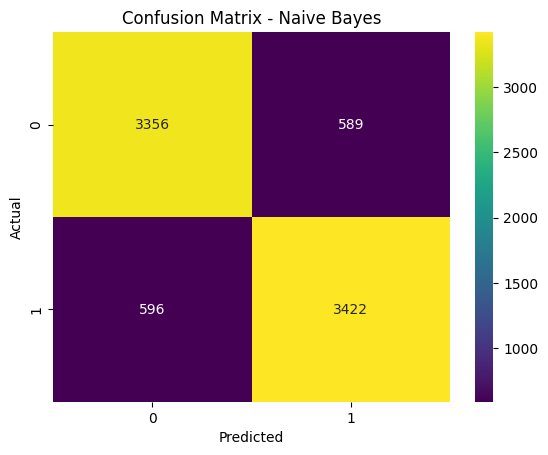

In [21]:
cm = confusion_matrix(y_test, y_pred_nb)  # Example: Logistic Regression
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


##**SVM**
####Separates classes using a hyperplane.

In [22]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.8867261082506593
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3945
           1       0.89      0.89      0.89      4018

    accuracy                           0.89      7963
   macro avg       0.89      0.89      0.89      7963
weighted avg       0.89      0.89      0.89      7963



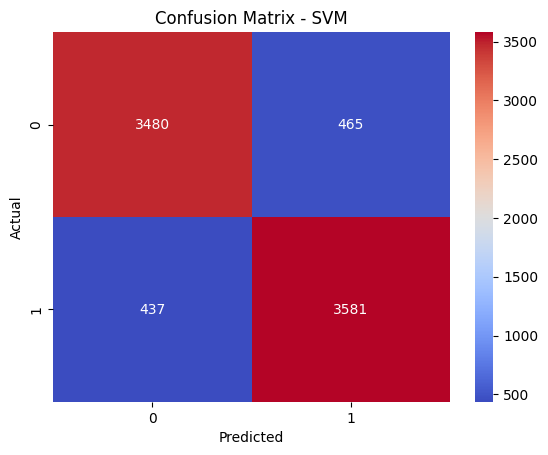

In [29]:
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

##**Random Forest Classifier**

####Handles overfitting better than a single decision tree.

In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.845661182971242
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      3945
           1       0.85      0.84      0.85      4018

    accuracy                           0.85      7963
   macro avg       0.85      0.85      0.85      7963
weighted avg       0.85      0.85      0.85      7963



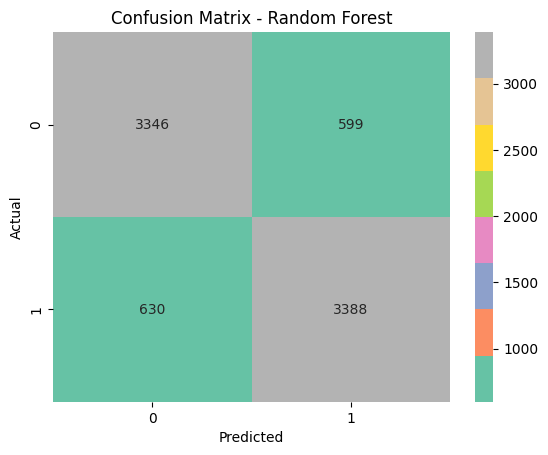

In [30]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Set2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


#### Performance metrics for each model using classification_report and accuracy_score.

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return [model_name, acc, prec, rec, f1]

results = []
results.append(evaluate_model(y_test, y_pred_lr, "Logistic Regression"))
results.append(evaluate_model(y_test, y_pred_nb, "Naive Bayes"))
results.append(evaluate_model(y_test, y_pred_svm, "SVM"))
results.append(evaluate_model(y_test, y_pred_rf, "Random Forest"))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.888359   0.885630  0.894226  0.889907
1          Naive Bayes  0.851187   0.853154  0.851667  0.852410
2                  SVM  0.886726   0.885072  0.891239  0.888145
3        Random Forest  0.845661   0.849762  0.843206  0.846471


##Ploted accuracy (and other metrics) for better comparison.

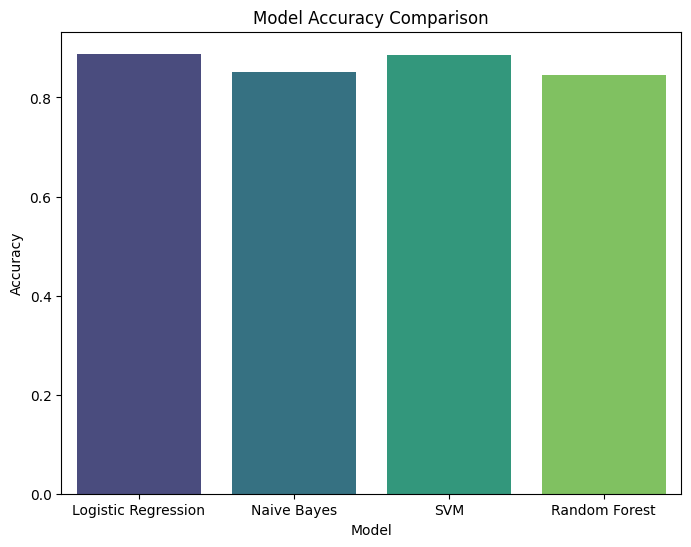

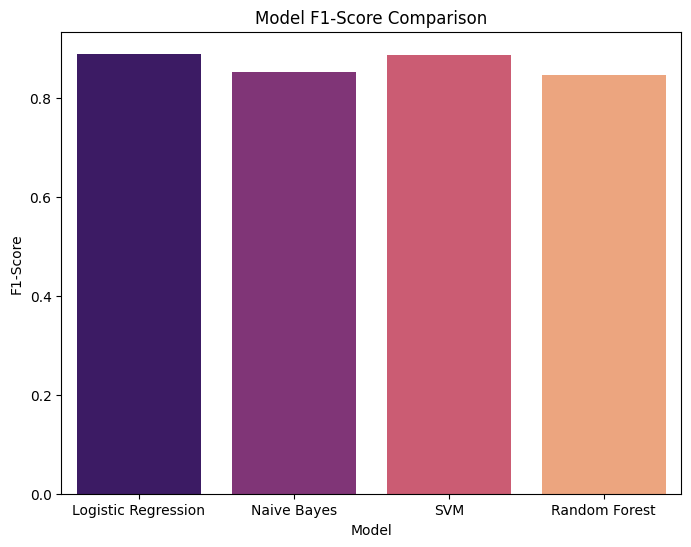

In [32]:
plt.figure(figsize=(8,6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x="Model", y="F1-Score", data=results_df, palette="magma")
plt.title("Model F1-Score Comparison")
plt.ylabel("F1-Score")
plt.show()


##Used joblib to save and load the trained model + vectorizer.

In [33]:
joblib.dump(log_reg, "sentiment_model.pkl")

joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!
